# 训练模型

## 1.导入包

In [35]:
import pandas as pd
import numpy as np


from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
from xgboost import plot_importance
import matplotlib.pyplot as plt
#StatsModels是一个统计模型库，提供了许多统计分析方法和模型。它包含了计算自相关函数和偏相关函数的函数，并可以轻松地绘制相关图表。
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from joblib import dump, load
%matplotlib inline

## 2.读取数据

In [36]:
df = pd.read_csv('../data/Data_Perpared.csv', compression = 'gzip')


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              878400 non-null  object 
 1   pickup_cluster  878400 non-null  int64  
 2   request_count   878400 non-null  float64
 3   mins            878400 non-null  int64  
 4   hour            878400 non-null  int64  
 5   day             878400 non-null  int64  
 6   month           878400 non-null  int64  
 7   dayofweek       878400 non-null  int64  
 8   quarter         878400 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 60.3+ MB


In [38]:
df['request_count'] = pd.to_numeric(df['request_count'],downcast='integer')
df.ts = pd.to_datetime(df.ts)
df.head()

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1


In [39]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,12
878396,2021-03-26 22:00:00,49,0,22,3,1,4,9
878397,2021-03-26 22:30:00,49,30,22,3,1,4,8
878398,2021-03-26 23:00:00,49,0,23,3,1,4,9


## 3.拆分测试集和训练集

In [40]:
df_train = df[df.ts.dt.day <= 23]
df_test = df[df.ts.dt.day > 23]

In [41]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]


In [42]:
# 定于模型评估函数
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# 版本1
Feature ：['pickup_cluster','mins','hour','month','quarter','dayofweek']
## 线性回归

In [43]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE Train: {},RMSE TEST: {}".format(sqrt(mean_squared_error(y,regressor.predict(X))),metrics_calculate(regressor)))

RMSE Train: 6.4581259773461195,RMSE TEST: 6.392836591882536


## 随机森林

In [44]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1,verbose=True)
regressor.fit(X,y)
print("RMSE Train: {},RMSE TEST: {}".format(sqrt(mean_squared_error(y,regressor.predict(X))),metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    2.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


RMSE Train: 1.8985907179427164,RMSE TEST: 4.118181919733644


[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.9s finished


In [45]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                      index = X.columns,    
                                      columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.404095
hour,0.266986
month,0.138083
quarter,0.102911
dayofweek,0.070160
mins,0.017766


## XGBoost

In [46]:
# 引入XGBoost库
import xgboost as xgb

# 创建XGBoost回归模型对象
model = xgb.XGBRegressor(learning_rate=0.01,random_state=0,n_estimators=1000,max_depth=8,objective='reg:squarederror')

eval_set = [(X_test, y_test)]
# 模型训练
model.fit(
    X, y,
     verbose=True,
     eval_set=eval_set, # 指定验证集
     early_stopping_rounds=15 ,# 15轮内，验证集的rmse没有提升，就停止训练
     eval_metric = "rmse" # 评估指标选择均方根误差（Root Mean Squared Error）
    )


# 模型性能
print("XGBOOST Regressor训练结束")
print("Model Score:",model.score(X,y))
print("RMSE Train: {},RMSE TEST: {}".format(sqrt(mean_squared_error(y,model.predict(X))),metrics_calculate(model)))

[0]	validation_0-rmse:7.45425


c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:7.41405
[2]	validation_0-rmse:7.37449
[3]	validation_0-rmse:7.33560
[4]	validation_0-rmse:7.29742
[5]	validation_0-rmse:7.26045
[6]	validation_0-rmse:7.22419
[7]	validation_0-rmse:7.18849
[8]	validation_0-rmse:7.15336
[9]	validation_0-rmse:7.11887
[10]	validation_0-rmse:7.08482
[11]	validation_0-rmse:7.05151
[12]	validation_0-rmse:7.01856
[13]	validation_0-rmse:6.98635
[14]	validation_0-rmse:6.95488
[15]	validation_0-rmse:6.92337
[16]	validation_0-rmse:6.89287
[17]	validation_0-rmse:6.86287
[18]	validation_0-rmse:6.83334
[19]	validation_0-rmse:6.80375
[20]	validation_0-rmse:6.77526
[21]	validation_0-rmse:6.74672
[22]	validation_0-rmse:6.71915
[23]	validation_0-rmse:6.69160
[24]	validation_0-rmse:6.66476
[25]	validation_0-rmse:6.63860
[26]	validation_0-rmse:6.61258
[27]	validation_0-rmse:6.58667
[28]	validation_0-rmse:6.56165
[29]	validation_0-rmse:6.53706
[30]	validation_0-rmse:6.51272
[31]	validation_0-rmse:6.48849
[32]	validation_0-rmse:6.46442
[33]	validation_0

In [47]:
dump(model,"../Model/prediction_model_without_lag.joblib",compress=3)

['../Model/prediction_model_without_lag.joblib']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

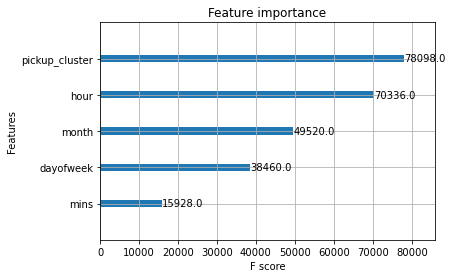

In [48]:
plot_importance(model)

# 版本2
Features:['pickup_cluster','mins','hour','month','quarter','dayofweek','lag1','lag2','lag3']

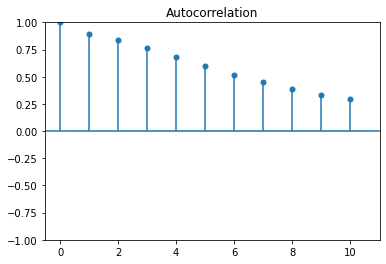

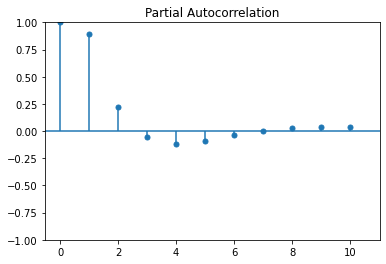

In [49]:
plot_acf(df.request_count,lags=10)
plot_pacf(df.request_count,lags=10)
plt.show()

In [50]:
#处理数据集——构建滞后特征
df_test = df_test.sort_values(by=["pickup_cluster","ts"]).drop_duplicates(subset=["pickup_cluster","ts"])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=["pickup_cluster","ts"]).drop_duplicates(subset=["pickup_cluster","ts"])


temp = temp.set_index(['pickup_cluster','mins','hour','month','quarter','dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)


temp.head(20)

ts  \
pickup_cluster mins hour month quarter dayofweek                       
0              0    0    3     1       3         2020-03-26 00:00:00   
               30   0    3     1       3         2020-03-26 00:30:00   
               0    1    3     1       3         2020-03-26 01:00:00   
               30   1    3     1       3         2020-03-26 01:30:00   
               0    2    3     1       3         2020-03-26 02:00:00   
               30   2    3     1       3         2020-03-26 02:30:00   
               0    3    3     1       3         2020-03-26 03:00:00   
               30   3    3     1       3         2020-03-26 03:30:00   
               0    4    3     1       3         2020-03-26 04:00:00   
               30   4    3     1       3         2020-03-26 04:30:00   
               0    5    3     1       3         2020-03-26 05:00:00   
               30   5    3     1       3         2020-03-26 05:30:00   
               0    6    3     1       3         2020-03-26 06:00:00   
               30   6    3     1       3         2020-03-26 06:30:00   
               0    7    3     1       3         2020-03-26 07:00:00   
               30   7    3     1       3         2020-03-26 07:30:00   
               0    8    3     1       3         2020-03-26 08:00:00   
               30   8    3     1       3         2020-03-26 08:30:00   
               0    9    3     1       3         2020-03-26 09:00:00   
               30   9    3     1       3         2020-03-26 09:30:00   

                                                  request_count  lag_1  lag_2  \
pickup_cluster mins hour month quarter dayofweek                                
0              0    0    3     1       3                      0    NaN    NaN   
               30   0    3     1       3                      0    0.0    NaN   
               0    1    3     1       3                      0    0.0    0.0   
               30   1    3     1       3                      0    0.0    0.0   
               0    2    3     1       3                      0    0.0    0.0   
               30   2    3     1       3                      0    0.0    0.0   
               0    3    3     1       3                      0    0.0    0.0   
               30   3    3     1       3                      0    0.0    0.0   
               0    4    3     1       3                      0    0.0    0.0   
               30   4    3     1       3                      0    0.0    0.0   
               0    5    3     1       3                      0    0.0    0.0   
               30   5    3     1       3                      0    0.0    0.0   
               0    6    3     1       3                      0    0.0    0.0   
               30   6    3     1       3                      2    0.0    0.0   
               0    7    3     1       3                      0    2.0    0.0   
               30   7    3     1       3                      0    0.0    2.0   
               0    8    3     1       3                      0    0.0    0.0   
               30   8    3     1       3                      1    0.0    0.0   
               0    9    3     1       3                      0    1.0    0.0   
               30   9    3     1       3                      0    0.0    1.0   

                                                  lag_3  
pickup_cluster mins hour month quarter dayofweek         
0              0    0    3     1       3            NaN  
               30   0    3     1       3            NaN  
               0    1    3     1       3            NaN  
               30   1    3     1       3            0.0  
               0    2    3     1       3            0.0  
               30   2    3     1       3            0.0  
               0    3    3     1       3            0.0  
               30   3    3     1       3            0.0  
               0    4    3     1       3            0.0  
               30   4    3     1       3            0.0  
  

In [51]:
temp = temp.reset_index(drop=False)
temp = temp.dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'request_count']]

In [52]:
temp.head(20)

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,lag_1,lag_2,lag_3,request_count
3,2020-03-26 01:30:00,0,30,1,3,1,3,0.0,0.0,0.0,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0,0.0,0.0,0
5,2020-03-26 02:30:00,0,30,2,3,1,3,0.0,0.0,0.0,0
6,2020-03-26 03:00:00,0,0,3,3,1,3,0.0,0.0,0.0,0
7,2020-03-26 03:30:00,0,30,3,3,1,3,0.0,0.0,0.0,0
8,2020-03-26 04:00:00,0,0,4,3,1,3,0.0,0.0,0.0,0
9,2020-03-26 04:30:00,0,30,4,3,1,3,0.0,0.0,0.0,0
10,2020-03-26 05:00:00,0,0,5,3,1,3,0.0,0.0,0.0,0
11,2020-03-26 05:30:00,0,30,5,3,1,3,0.0,0.0,0.0,0
12,2020-03-26 06:00:00,0,0,6,3,1,3,0.0,0.0,0.0,0


In [53]:
#拆分测试集和训练集
train1 = temp[temp.ts.dt.day <= 23]
test1 = temp[temp.ts.dt.day > 23] 

In [54]:
X = train1.iloc[:,1:-1]
y = train1.iloc[:,-1]
X_test = test1.iloc[:,1:-1]
y_test = test1.iloc[:,-1]

## 随机森林2.0

In [55]:
#随机森林

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.9644126536190422, RMSE TEST:2.561998446998927


In [56]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                      index = X.columns,    
                                      columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.796461
hour,0.045548
pickup_cluster,0.040300
lag_2,0.037678
lag_3,0.029348
dayofweek,0.020226
month,0.018242
mins,0.007849
quarter,0.004349


## XGBoost2.0

In [57]:


# 创建XGBoost回归模型对象
model = xgb.XGBRegressor(learning_rate=0.01,random_state=0,n_estimators=1000,max_depth=8,objective='reg:squarederror')

eval_set = [(X_test, y_test)]
# 模型训练
model.fit(
    X, y,
     verbose=True,
     eval_set=eval_set, # 指定验证集
     early_stopping_rounds=15 ,# 15轮内，验证集的rmse没有提升，就停止训练
     eval_metric = "rmse" # 评估指标选择均方根误差（Root Mean Squared Error）
    )


# 模型性能
print("XGBOOST Regressor训练结束")
print("Model Score:",model.score(X,y))
print("RMSE Train: {},RMSE TEST: {}".format(sqrt(mean_squared_error(y,model.predict(X))),metrics_calculate(model)))

[0]	validation_0-rmse:7.43345


c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:7.36980
[2]	validation_0-rmse:7.30681
[3]	validation_0-rmse:7.24453
[4]	validation_0-rmse:7.18289
[5]	validation_0-rmse:7.12208
[6]	validation_0-rmse:7.06191
[7]	validation_0-rmse:7.00247
[8]	validation_0-rmse:6.94367
[9]	validation_0-rmse:6.88560
[10]	validation_0-rmse:6.82806
[11]	validation_0-rmse:6.77132
[12]	validation_0-rmse:6.71512
[13]	validation_0-rmse:6.65982
[14]	validation_0-rmse:6.60501
[15]	validation_0-rmse:6.55079
[16]	validation_0-rmse:6.49727
[17]	validation_0-rmse:6.44428
[18]	validation_0-rmse:6.39196
[19]	validation_0-rmse:6.34007
[20]	validation_0-rmse:6.28901
[21]	validation_0-rmse:6.23842
[22]	validation_0-rmse:6.18862
[23]	validation_0-rmse:6.13927
[24]	validation_0-rmse:6.09054
[25]	validation_0-rmse:6.04224
[26]	validation_0-rmse:5.99484
[27]	validation_0-rmse:5.94784
[28]	validation_0-rmse:5.90135
[29]	validation_0-rmse:5.85566
[30]	validation_0-rmse:5.81039
[31]	validation_0-rmse:5.76542
[32]	validation_0-rmse:5.72132
[33]	validation_0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

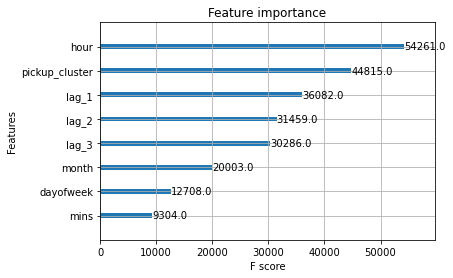

In [58]:
plot_importance(model)

# 版本3.0--加入滚动均值

In [70]:
# 首先对测试数据集按照pickup_cluster和ts进行排序，并删除重复的ts和pickup_cluster条目
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])

# 将训练数据集和处理后的测试数据集合并为一个新的数据集temp
temp = pd.concat([df_train,df_test])

# 对temp数据集按照pickup_cluster和ts进行排序，并删除重复的ts和pickup_cluster条目，确保每个pickup_cluster在每个时间戳只有唯一的一条记录
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])

# 将temp数据集的索引设置为ts、pickup_cluster、mins、hour、month、quarter和dayofweek
temp = temp.set_index(['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek'])

# 创建4个列：3个滞后特征和一个滚动均值
# 滚动均值的窗口：3
# lag_1表示前一个时间步请求的数量，lag_2表示前两个时间步请求的数量，以此类推；rolling_mean表示滚动窗口大小为3的request_count的平均值,shift(1)表示将结果向下移动一行
#偏移一格的目的是保持数据的对齐。由于滚动平均是基于前一行的数据计算得出的，因此需要将结果向后偏移一格，
# 使得每一行的rolling_mean值对应的是上一行的滚动平均值，而不是当前行的滚动平均值。
temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp['rolling_mean'] = temp.groupby(level=['pickup_cluster'])['request_count'].apply(lambda x: x.rolling(3).mean()).shift(1)


# 重新设置包含重复值的索引，并删除任何包含空值的行
temp = temp.reset_index(drop=False).dropna()


# 只选择需要的列，存入temp中
temp = temp[['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter','dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean','request_count']]

# 将日期在23日及其之前的数据作为训练集，并将日期在24日及其之后的数据作为测试集
train1 = temp[temp.ts.dt.day <= 23]
test1 = temp[temp.ts.dt.day > 23]


# 提取训练集和测试集中除了目标变量外的所有特征作为输入X和X_test，提取目标变量request_count作为y和y_test
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [71]:
# 这里我们不使用随机森林模型，因为随机森林模型出现过于拟合的情况，模型的泛化能力较差

In [72]:
# 创建XGBoost回归模型对象
model = xgb.XGBRegressor(learning_rate=0.01,random_state=0,n_estimators=2000,max_depth=8,objective='reg:squarederror')

eval_set = [(X_test, y_test)]
# 模型训练
model.fit(
    X, y,
     verbose=True,
     eval_set=eval_set, # 指定验证集
     early_stopping_rounds=20 ,# 20轮内，验证集的rmse没有提升，就停止训练
     eval_metric = "rmse" # 评估指标选择均方根误差（Root Mean Squared Error）
    )


# 模型性能
print("XGBOOST Regressor训练结束")
print("Model Score:",model.score(X,y))
print("RMSE Train: {},RMSE TEST: {}".format(sqrt(mean_squared_error(y,model.predict(X))),metrics_calculate(model)))

[0]	validation_0-rmse:7.43331


c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\20228\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:7.36950
[2]	validation_0-rmse:7.30634
[3]	validation_0-rmse:7.24393
[4]	validation_0-rmse:7.18213
[5]	validation_0-rmse:7.12116
[6]	validation_0-rmse:7.06073
[7]	validation_0-rmse:7.00109
[8]	validation_0-rmse:6.94198
[9]	validation_0-rmse:6.88358
[10]	validation_0-rmse:6.82583
[11]	validation_0-rmse:6.76882
[12]	validation_0-rmse:6.71245
[13]	validation_0-rmse:6.65672
[14]	validation_0-rmse:6.60158
[15]	validation_0-rmse:6.54708
[16]	validation_0-rmse:6.49319
[17]	validation_0-rmse:6.43999
[18]	validation_0-rmse:6.38734
[19]	validation_0-rmse:6.33538
[20]	validation_0-rmse:6.28408
[21]	validation_0-rmse:6.23329
[22]	validation_0-rmse:6.18304
[23]	validation_0-rmse:6.13354
[24]	validation_0-rmse:6.08451
[25]	validation_0-rmse:6.03626
[26]	validation_0-rmse:5.98851
[27]	validation_0-rmse:5.94125
[28]	validation_0-rmse:5.89438
[29]	validation_0-rmse:5.84836
[30]	validation_0-rmse:5.80261
[31]	validation_0-rmse:5.75767
[32]	validation_0-rmse:5.71332
[33]	validation_0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

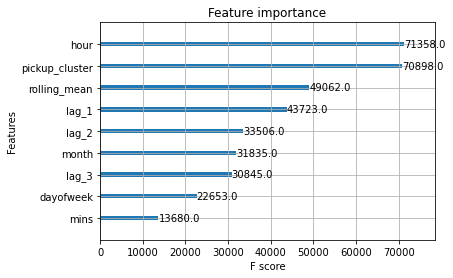

In [73]:
plot_importance(model)

In [74]:
dump(model,"../Model/prediction_model.joblib",compress=3)

['../Model/prediction_model.joblib']